## 4.1.6 재현 신경망(Recurrent Neural Network) 분류 모델

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import os
import json

from tqdm import tqdm

## 시각화

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## 학습 데이터 파일 로드

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

## 모델 정의

In [4]:
WORD_EMBEDDING_DIM = 100
HIDDEN_STATE_DIM =150
DENSE_FEATURE_DIM = 150

model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'vocab_size': prepro_configs['vocab_size']+1,
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

In [12]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=model_name) # name=model name?
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
        
    def build_graph(self, input_shape):
        input_shape_wo_batch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_wo_batch)
        
        _ = self.call(inputs)


In [13]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build_graph(input_shape=(BATCH_SIZE, MAX_LEN))
model.summary()

(128, 174, 100)
(None, 174, 100)
Model: "rnn_classifier_en"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 174, 100)          7406600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 174, 150)          150600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 7,760,601
Trainable params: 7,760,601
Non-trainable params: 0
______

In [7]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

./data_out/rnn_classifier_en -- Folder create complete 

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22400/22500 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5200
Epoch 00001: val_accuracy improved from -inf to 0.53320, saving model to ./data_out/rnn_classifier_en/weights.01-0.53.h5
22500/22500 [==============================] - 199s 9ms/sample - loss: 0.6925 - accuracy: 0.5202 - val_loss: 0.6853 - val_accuracy: 0.5332
Epoch 2/5
22400/22500 [============================>.] - ETA: 0s - loss: 0.6318 - accuracy: 0.6425
Epoch 00002: val_accuracy did not improve from 0.53320
22500/22500 [==============================] - 187s 8ms/sample - loss: 0.6320 - accuracy: 0.6422 - val_loss: 0.6917 - val_accuracy: 0.4952


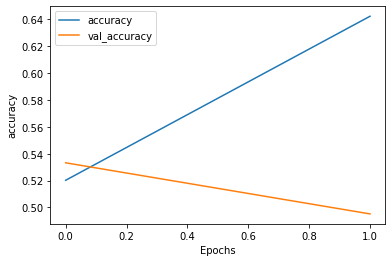

In [8]:
plot_graphs(history, 'accuracy')

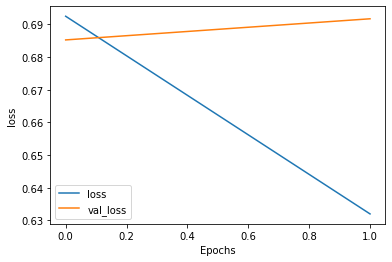

In [9]:
plot_graphs(history, 'loss')

## 캐글 평가 데이터셋 만들기 

In [10]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'
SAVE_FILE_NM = 'weights.04-0.89.h5'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [11]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

OSError: Unable to open file (unable to open file: name = './data_out/rnn_classifier_en/weights.04-0.89.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
BLOCK_SIZE = 500

predictions = [model(test_input[i*BLOCK_SIZE:i*BLOCK_SIZE+BLOCK_SIZE]).numpy() \
               for i in tqdm(range(test_input.shape[0] // BLOCK_SIZE))]

In [ ]:
predictions = np.concatenate(predictions, axis=-2).squeeze(-1)

In [ ]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

In [ ]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)} )
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3 )

### Kaggle 점수 확인

![alt text](images/rnn_classification_score.png "Title") 